In [ ]:
# !pip install lightgbm==3.3.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.9 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from itertools import product
import warnings
import numpy as np
import json
from datetime import datetime
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, accuracy_score
from tqdm import tqdm
import joblib

In [ ]:
import torch
from torch.nn import LSTM, Linear, ReLU, Sigmoid, Dropout, Conv1d, MaxPool1d
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

# Обработка данных

In [ ]:
data = pd.read_csv('drive/MyDrive/trade_sys/gazp.csv', sep=',') # загружаем данные
data.drop(labels=['<PER>', '<TIME>'], axis=1, inplace=True) # убираем из таблицы ненужные столбцы
data.rename({'<TICKER>': 'company', '<CLOSE>': 'close', '<DATE>': 'date'}, axis=1, inplace=True) # переименовываем оставшиеся столбцы
data['date'] = pd.to_datetime(data['date'], dayfirst=True) # приводим столбец с датами к нужному формату
data.set_index('date', inplace=True)
data.head()

,company,close
date,,
2010-01-11,GAZP,194.50
2010-01-12,GAZP,191.80
2010-01-13,GAZP,189.30
2010-01-14,GAZP,190.83
2010-01-15,GAZP,187.86


In [ ]:
min(data.index), max(data.index)

(Timestamp('2010-01-11 00:00:00'), Timestamp('2022-12-30 00:00:00'))

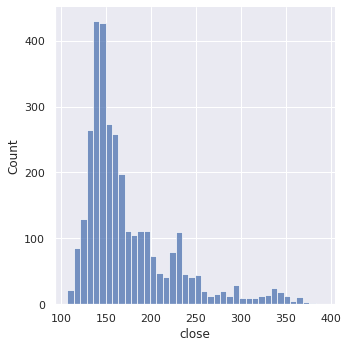

In [ ]:
sns.displot(data.close)

In [ ]:
data.describe()

,close
count,3250.000000
mean,174.658982
std,51.103808
min,107.230000
25%,140.627500
50%,156.495000
75%,193.857500
max,389.820000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3250 entries, 2010-01-11 to 2022-12-30
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   company  3250 non-null   object 
 1   close    3250 non-null   float64
dtypes: float64(1), object(1)
memory usage: 76.2+ KB


<Figure size 1440x720 with 0 Axes>

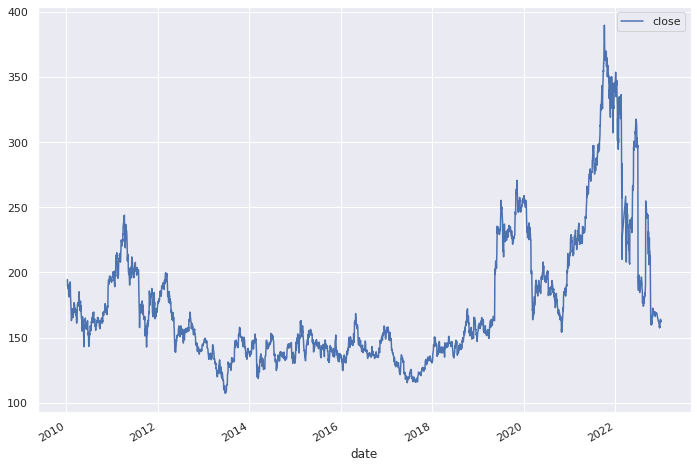

In [ ]:
fig = plt.figure(figsize=(20, 10))
#sns.set()
data.plot()
plt.show()

In [ ]:
WINDOW_SIZE = 60

In [ ]:
def prepare_data(data: pd.DataFrame, mode='regression', WINDOW_SIZE=WINDOW_SIZE, test_size=30):
  X, y = np.array([]).reshape(-1, WINDOW_SIZE), np.array([]).reshape(-1, 1)
  n = data.close.values.shape[0]
  for i in range(n - WINDOW_SIZE - 1):
    X = np.append(X, np.array(data.close.values[i:i + WINDOW_SIZE], ndmin=2), axis=0)
    if mode == 'regression':
      y = np.append(y, np.array([data.close.values[i + WINDOW_SIZE]], ndmin=2), axis=0)
    else:
      flg = int(data.close.values[i + WINDOW_SIZE - 1] < data.close.values[i + WINDOW_SIZE])
      y = np.append(y, np.array([flg], ndmin=2), axis=0)
  X_train, y_train = X[:-test_size], y[: -test_size]
  X_test, y_test = X[-test_size:], y[-test_size:]
  return X_train, y_train, X_test, y_test

In [ ]:
class FCModel(nn.Module):

  def __init__(self, input_size):
    super(FCModel, self).__init__()
    self.fc1 = Linear(input_size, 128)
    self.fc2 = Linear(128, 64)
    self.fc3 = Linear(64, 32)
    self.fc4 = Linear(32, 16)
    self.fc5 = Linear(16, 1)
    self.relu = ReLU()

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.fc4(x)
    x = self.relu(x)
    x = self.fc5(x)
    return x
  
  def infer(self, x, threshold=.5):
    preds = Sigmoid()(self.forward(x))
    return (preds >= threshold).float()

In [ ]:
# cropped_data = data.loc[data.index < '2019-02-01']
# X_train, y_train, X_test, y_test = prepare_data(cropped_data, 'classification')

In [ ]:
# train_data = torch.tensor(X_train, dtype=torch.float32)
# train_target = torch.tensor(y_train)
# train_dataloader = DataLoader(TensorDataset(train_data, train_target), batch_size=len(train_data))
# test_data = torch.tensor(X_test, dtype=torch.float32)
# test_target = torch.tensor(y_test)
# test_dataloader = DataLoader(TensorDataset(test_data, test_target), batch_size=len(test_data))

In [ ]:
def train_model(model, loss, optimizer, num_epochs):
  history = {'train': [],
             'val': []}
  # epochs = tqdm(range(num_epochs))
  epochs = range(num_epochs)
  for epoch in epochs:
    # print(f'Epoch {epoch}/{num_epochs - 1}')
    for mode in ['train', 'val']:
      if mode == 'train':
        dataloader = train_dataloader
        model.train()
      else:
        dataloader = test_dataloader
        model.eval()
      
      running_loss = 0.
      running_acc = 0.

      for input, labels in dataloader:
        input = input[None, :]
        input = input.permute(1, 0, 2)
        input = input.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(mode == 'train'):
          preds = model(input)
          losses = loss(preds, labels)
          pred_class = model.infer(input)

          if mode == 'train':
            losses.backward()
            optimizer.step()

        running_loss += losses.item()
        running_acc += (pred_class == labels.data).float().mean()

      epoch_loss = running_loss / len(dataloader)
      epoch_acc = running_acc / len(dataloader)
      history[mode].append(epoch_loss)

      # if mode == 'val':
      #   epochs.set_description('Val loss: {:.4f} Val acc: {:.4f}'.format(epoch_loss, epoch_acc))

  return history

In [ ]:
class LSTMModel(nn.Module):

  def __init__(self, input_size):
    super(LSTMModel, self).__init__()
    self.lstm = LSTM(input_size=input_size, num_layers=1, 
                     hidden_size=16, batch_first=True)
    self.fc1 = Linear(16, 1)

  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc1(out)
    return out
  
  def infer(self, x, threshold=.5):
    preds = Sigmoid()(self.forward(x))
    return (preds >= threshold).float()

In [ ]:
class CNNModel(nn.Module):

  def __init__(self, input_size):
    self.input_size = input_size
    super(CNNModel, self).__init__()
    self.conv1 = Conv1d(in_channels=1, out_channels=1, kernel_size=30)
    self.conv2 = Conv1d(in_channels=1, out_channels=1, kernel_size=7)
    self.mp = MaxPool1d(kernel_size=2, stride=1)
    self.relu = ReLU()
    self.fc1 = Linear(self.input_size - 36, 1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.mp(x)
    x = self.relu(x)
    x = x.view(-1, self.input_size - 36)
    x = self.fc1(x)
    return x
  
  def infer(self, x, threshold=.5):
    preds = Sigmoid()(self.forward(x))
    return (preds >= threshold).float()

In [ ]:
# model = CNNModel(WINDOW_SIZE)
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# loss_function = nn.BCEWithLogitsLoss()
# optimizer = Adam(model.parameters(), lr=0.0001)

In [ ]:
# history = train_model(model, loss_function, optimizer, 2000)

In [ ]:
# plt.plot(history['train'])
# plt.plot(history['val'])
# plt.legend(['train', 'val'])

In [ ]:
# f1_score(model.infer(test_data), test_target)

In [ ]:
models = [LogisticRegression(solver='liblinear'), CatBoostClassifier(n_estimators=800), XGBClassifier(n_estimators=800), LGBMClassifier(n_estimators=800)]
windows = [7, 14, 30, 60, 90, 180]

In [ ]:
# model = LGBMClassifier(n_estimators=800)
# cropped_data = data.loc[data.index < '2018-02-01']
# X_train, y_train, X_test, y_test = prepare_data(cropped_data, 'classification')
# model.fit(X_train, y_train)
# joblib.dump(model, 'model_aero.bin')
# model = joblib.load('model_aero.bin')
# y_pred = model.predict(X_test)
# print(f1_score(y_test, y_pred))

In [ ]:
dates = ['2019-02-01',
         '2019-03-01',
         '2019-04-01',
         '2019-05-01',
         '2019-06-01',
         '2019-07-01',
         '2019-08-01',
         '2019-09-01',
         '2019-10-01',
         '2019-11-01',
         '2019-12-01',
         '2020-01-01',]

In [ ]:
results = {
    'accuracy': {
      'XGBClassifier': [],
      'LogisticRegression': [],
      'CatBoostClassifier': [],
      'LGBMClassifier': [],
    },
    'f1_score': {
      'XGBClassifier': [],
      'LogisticRegression': [],
      'CatBoostClassifier': [],
      'LGBMClassifier': [],
    }
}

In [ ]:
for model in models:
  for win_size in tqdm(windows):
    f1_scores, acc_scores = [], []
    for date in dates:
      cropped_data = data.loc[data.index < date]
      X_train, y_train, X_test, y_test = prepare_data(cropped_data, 'classification', win_size)
      model_temp = model
      model_temp.fit(X_train, y_train)
      test_preds = model_temp.predict(X_test)
      f1_scores.append(f1_score(y_test, test_preds))
      acc_scores.append(accuracy_score(y_test, test_preds))
    results['accuracy'][type(model_temp).__name__].append(sum(acc_scores) / len(acc_scores))
    results['f1_score'][type(model_temp).__name__].append(sum(f1_scores) / len(f1_scores))

In [ ]:
nn_models = ["FCModel", "LSTMModel"]

In [ ]:
nn_results = {
    'accuracy': {
      'FCModel': [],
      'CNNModel': [],
      'LSTMModel': [],
    },
    'f1_score': {
      'FCModel': [],
      'CNNModel': [],
      'LSTMModel': [],
    }
}

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

loss_function = nn.BCEWithLogitsLoss()

In [ ]:
for model in nn_models:
  for win_size in tqdm(windows):
    f1_scores, acc_scores = [], []
    for date in dates:
      cropped_data = data.loc[data.index < date]
      X_train, y_train, X_test, y_test = prepare_data(cropped_data, 'classification', win_size)
      train_data = torch.tensor(X_train, dtype=torch.float32)
      train_data = train_data.to(device)
      train_target = torch.tensor(y_train)
      train_dataloader = DataLoader(TensorDataset(train_data, train_target), batch_size=len(train_data))
      test_data = torch.tensor(X_test, dtype=torch.float32)
      test_data = test_data.to(device)
      test_target = torch.tensor(y_test)
      test_dataloader = DataLoader(TensorDataset(test_data, test_target), batch_size=len(test_data))

      model_temp = globals()[model](win_size)
      model_temp = model_temp.to(device)
      optimizer = Adam(model_temp.parameters(), lr=0.0001)
      train_model(model_temp, loss_function, optimizer, 1000)

      test_preds = model_temp.infer(test_data)
      f1_scores.append(f1_score(test_target, test_preds.cpu()))
      acc_scores.append(accuracy_score(test_target, test_preds.cpu()))
    nn_results['accuracy'][type(model_temp).__name__].append(sum(acc_scores) / len(acc_scores))
    nn_results['f1_score'][type(model_temp).__name__].append(sum(f1_scores) / len(f1_scores))

100%|██████████| 6/6 [41:03<00:00, 410.63s/it]


In [ ]:
for win_size in tqdm(windows):
  f1_scores, acc_scores = [], []
  mean_acc, mean_f1 = np.nan, np.nan
  if win_size > 30:
    for date in dates:
      cropped_data = data.loc[data.index < date]
      X_train, y_train, X_test, y_test = prepare_data(cropped_data, 'classification', win_size)
      train_data = torch.tensor(X_train, dtype=torch.float32)
      train_data = train_data.to(device)
      train_target = torch.tensor(y_train)
      train_dataloader = DataLoader(TensorDataset(train_data, train_target), batch_size=len(train_data))
      test_data = torch.tensor(X_test, dtype=torch.float32)
      test_data = test_data.to(device)
      test_target = torch.tensor(y_test)
      test_dataloader = DataLoader(TensorDataset(test_data, test_target), batch_size=len(test_data))

      model_temp = CNNModel(win_size)
      model_temp = model_temp.to(device)
      optimizer = Adam(model_temp.parameters(), lr=0.0001)
      train_model(model_temp, loss_function, optimizer, 1000)
      test_data = test_data[None, :]
      test_data = test_data.permute(1, 0, 2)
      test_preds = model_temp.infer(test_data)
      f1_scores.append(f1_score(test_target, test_preds.cpu()))
      acc_scores.append(accuracy_score(test_target, test_preds.cpu()))
    mean_acc, mean_f1 = sum(acc_scores) / len(acc_scores), sum(f1_scores) / len(f1_scores)
  nn_results['accuracy']['CNNModel'].append(mean_acc), 
  nn_results['f1_score']['CNNModel'].append(mean_f1)

100%|██████████| 6/6 [14:33<00:00, 145.59s/it]


In [ ]:
all_results = results
for key in nn_results.keys():
  for m_name in nn_results[key].keys():
    all_results[key][m_name] = nn_results[key][m_name]

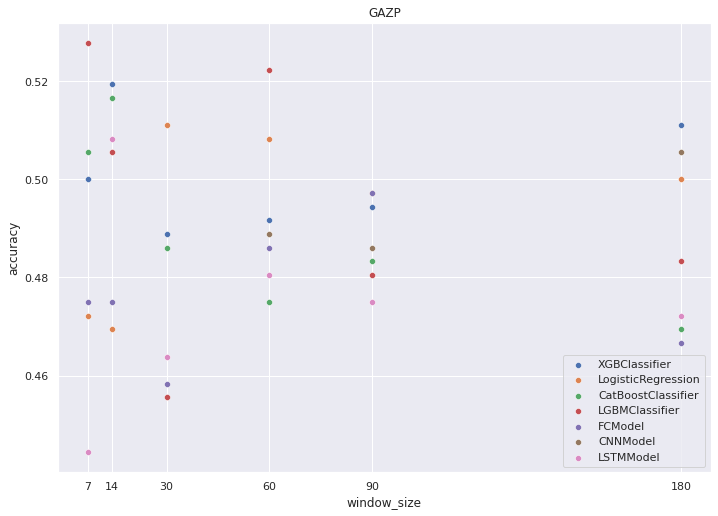

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
for name in all_results['accuracy'].keys():
  sns.scatterplot(x=windows, y=all_results['accuracy'][name], label=name)
plt.xticks(windows)
plt.ylabel('accuracy')
plt.xlabel('window_size')
plt.title('GAZP')
plt.show()

In [ ]:
pd.DataFrame(all_results).to_csv('gazp_models.csv')

In [ ]:
# def predict_model(model, train_data: pd.DataFrame):
#   y_pred = []
#   X_temp = np.array(train_data.close.values[-WINDOW_SIZE:], ndmin=2)
#   for i in range(WINDOW_SIZE):
#     temp_pred = model.predict(X_temp)
#     X_temp = np.append(X_temp[:, 1:], np.array(temp_pred, ndmin=2), axis=1)
#     y_pred.append(temp_pred[0])
#   return np.array(y_pred).reshape(-1, 1)
# y_pred = predict_model(model, train_data)

In [ ]:
# model.save_model('model.bin')
# model.load_model('model.bin')

<AxesSubplot:>

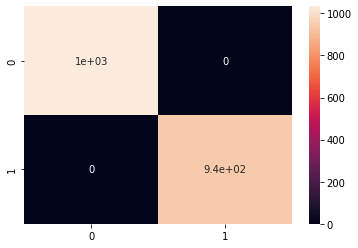

In [ ]:
train_preds = model.predict(X_train)
train_cm = confusion_matrix(y_train, train_preds)
sns.heatmap(train_cm, annot=True)

In [ ]:
(train_cm[0][0] + train_cm[1][1]) / train_cm.sum()

1.0

In [ ]:
y_preds = model.predict(X_test)

<AxesSubplot:>

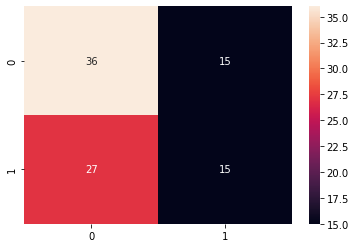

In [ ]:
cm = confusion_matrix(y_test, y_preds)
sns.heatmap(cm, annot=True)

In [ ]:
acc = (cm[0][0] + cm[1][1]) / cm.sum()
acc

0.5483870967741935

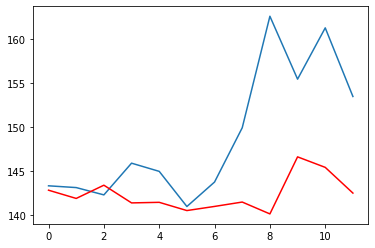

In [ ]:
plt.plot(test_data.close.values)
plt.plot(y_pred, color='r')

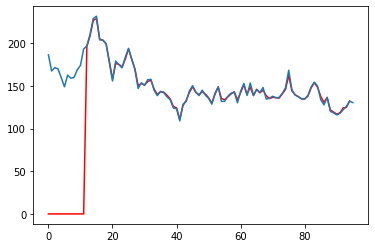

In [ ]:
plt.plot(np.append(np.zeros(WINDOW_SIZE), y_pred), color='r')
plt.plot(train_data.close.values)

p=0.169450


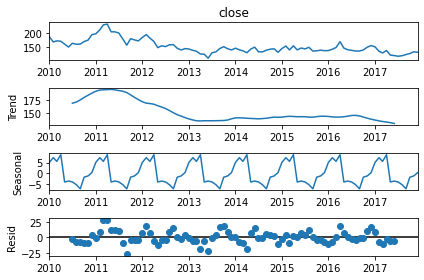

In [ ]:
sm.tsa.seasonal_decompose(train_data.close).plot()
print('p=%f' % sm.tsa.stattools.adfuller(train_data.close)[1])

<ipython-input-81-9b285ee9b3f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['close_box'], lmbda = stats.boxcox(train_data.close)


Оптимальная лямбда: -1.898814
p=0.090813


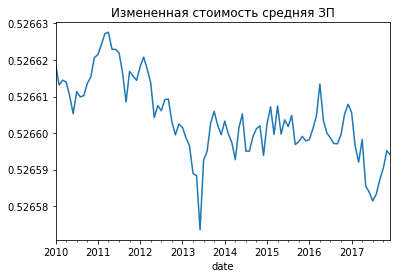

In [ ]:
train_data['close_box'], lmbda = stats.boxcox(train_data.close)
plt.figure()
train_data.close_box.plot()
plt.title('Измененная стоимость средняя ЗП')
print('Оптимальная лямбда: %f' % lmbda)
print('p=%f' % sm.tsa.stattools.adfuller(train_data.close_box)[1])

<ipython-input-82-f570d693c53f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['close_box_diff'] = train_data.close_box - train_data.close_box.shift(12)


p=0.461905


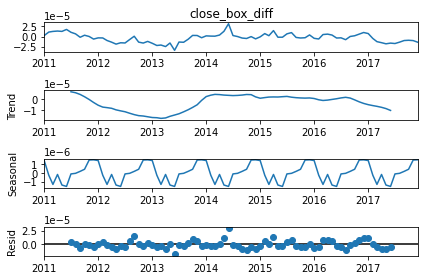

In [ ]:
train_data['close_box_diff'] = train_data.close_box - train_data.close_box.shift(12)
sm.tsa.seasonal_decompose(train_data.close_box_diff.dropna()).plot()
print('p=%f' % sm.tsa.stattools.adfuller(train_data.close_box_diff.dropna())[1])

<ipython-input-83-7c973fd7af0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['close_box_diff2'] = train_data.close_box - train_data.close_box.shift(1)


p=0.000000


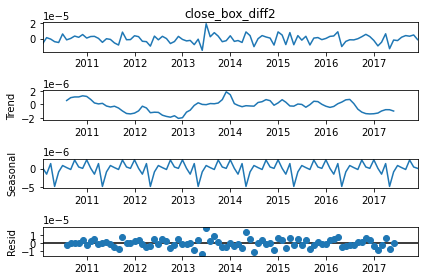

In [ ]:
train_data['close_box_diff2'] = train_data.close_box - train_data.close_box.shift(1)
sm.tsa.seasonal_decompose(train_data.close_box_diff2.dropna()).plot()
print('p=%f' % sm.tsa.stattools.adfuller(train_data.close_box_diff2.dropna())[1])

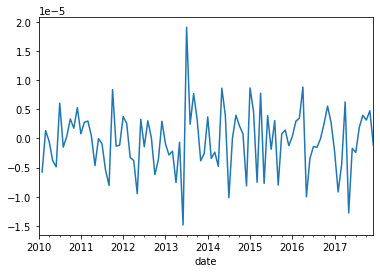

In [ ]:
train_data.close_box_diff2.plot()

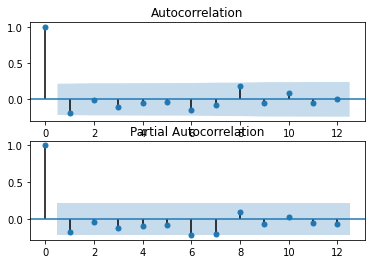

In [ ]:
plt.figure()
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_data.close_box_diff2.dropna()[12:].squeeze(), lags=12, ax=ax);
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_data.close_box_diff2.dropna()[12:].squeeze(), lags=12, ax=ax);

In [ ]:
p = range(0, 3)
d=1
q = range(0, 3)
P = range(0, 3)
D=1
Q = range(0, 2)

In [ ]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(parameters_list)
len(parameters_list)

[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 1, 0), (0, 0, 1, 1), (0, 0, 2, 0), (0, 0, 2, 1), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 1, 0), (0, 1, 1, 1), (0, 1, 2, 0), (0, 1, 2, 1), (0, 2, 0, 0), (0, 2, 0, 1), (0, 2, 1, 0), (0, 2, 1, 1), (0, 2, 2, 0), (0, 2, 2, 1), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 1), (1, 0, 2, 0), (1, 0, 2, 1), (1, 1, 0, 0), (1, 1, 0, 1), (1, 1, 1, 0), (1, 1, 1, 1), (1, 1, 2, 0), (1, 1, 2, 1), (1, 2, 0, 0), (1, 2, 0, 1), (1, 2, 1, 0), (1, 2, 1, 1), (1, 2, 2, 0), (1, 2, 2, 1), (2, 0, 0, 0), (2, 0, 0, 1), (2, 0, 1, 0), (2, 0, 1, 1), (2, 0, 2, 0), (2, 0, 2, 1), (2, 1, 0, 0), (2, 1, 0, 1), (2, 1, 1, 0), (2, 1, 1, 1), (2, 1, 2, 0), (2, 1, 2, 1), (2, 2, 0, 0), (2, 2, 0, 1), (2, 2, 1, 0), (2, 2, 1, 1), (2, 2, 2, 0), (2, 2, 2, 1)]


54

In [ ]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #используем try, чтобы предотвратить ошибки при обучении модели на некоторых параметрах
    
    try:
        model=sm.tsa.statespace.SARIMAX(train_data.close_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #выводим некорректные параметры
    
    except ValueError:
        print('Некорректные параметры:', param)
        continue
    aic = model.aic
    
    #сохраняем лучшую модель
    
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [ ]:
table = pd.DataFrame(results)
table.columns = ['params', 'aics']
print(table.sort_values(by = 'aics', ascending=True).head())

          params         aics
36  (2, 0, 0, 0) -1681.976907
24  (1, 1, 0, 0) -1680.733386
43  (2, 1, 0, 1) -1676.168544
44  (2, 1, 1, 0) -1671.231125
45  (2, 1, 1, 1) -1670.842259


In [ ]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          close_box   No. Observations:                   96
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 843.988
Date:                            Tue, 13 Dec 2022   AIC                          -1681.977
Time:                                    11:33:14   BIC                          -1674.720
Sample:                                01-01-2010   HQIC                         -1679.062
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2458   3.16e-19  -7.79e+17      0.000      -0.246      -0.246
ar.L2         -0.0832   5.24e-20  -

Критерий Стьюдента: p=0.959604
Критерий Дики-Фуллера: p=0.000000


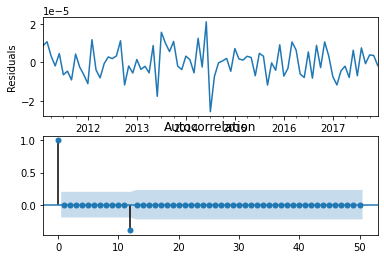

In [ ]:
plt.figure()
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=50, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [ ]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-93-10d40196c081>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['model'] = invboxcox(best_model.fittedvalues, lmbda)


Text(0.5, 1.0, 'Стоимость акции')

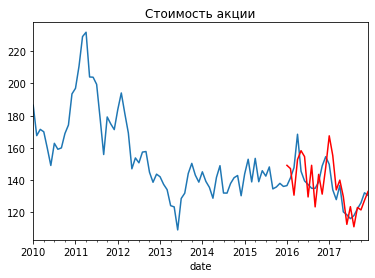

In [ ]:
train_data['model'] = invboxcox(best_model.fittedvalues, lmbda)

plt.figure()
train_data.close.plot()
train_data.model[-24:].plot(color='r')
plt.title('Стоимость акции')

In [ ]:
from datetime import *
from dateutil.relativedelta import *

Text(0.5, 1.0, 'Средняя ЗП')

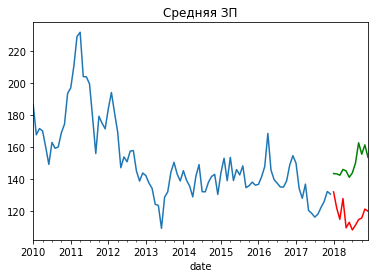

In [ ]:
fcst = train_data[['close']]
date_list = [datetime.strptime("2018-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns=fcst.columns)
fcst = pd.concat([fcst, future])
fcst['forecast'] = invboxcox(best_model.predict(start=96, end=108), lmbda)

plt.figure()
fcst.close.plot()
fcst.forecast.plot(color='r')
test_data.close.plot(color='g')
plt.title('Средняя ЗП')

In [ ]:
invboxcox(best_model.predict(start=60, end=72), lmbda)

2019-01-01    159.262851
2019-02-01    158.949030
2019-03-01    156.475328
2019-04-01    167.346429
2019-05-01    158.228387
2019-06-01    156.062682
2019-07-01    151.289791
2019-08-01    156.094654
2019-09-01    158.930245
2019-10-01    157.881017
2019-11-01    161.523632
2019-12-01    159.503880
2020-01-01    168.158396
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
fcst.forecast[~fcst.forecast.isna()]

2019-01-01    162.440960
2019-02-01    153.100242
2019-03-01    148.623336
2019-04-01    156.775683
2019-05-01    144.965216
2019-06-01    141.377012
2019-07-01    141.191218
2019-08-01    145.941304
2019-09-01    156.014413
2019-10-01    155.203807
2019-11-01    163.508417
2019-12-01    157.517653
Name: forecast, dtype: float64

In [ ]:
test_data.close

date
2019-01-01    162.82
2019-02-01    158.99
2019-03-01    149.61
2019-04-01    163.95
2019-05-01    215.10
2019-06-01    232.83
2019-07-01    236.90
2019-08-01    232.15
2019-09-01    225.90
2019-10-01    260.00
2019-11-01    257.54
2019-12-01    256.40
Name: close, dtype: float64